# ARLSTM
Auto Regressive Long Short Term Memory. It allows to make ouputs of our desired lenght by using the predicted values to make future predictions. It is a multi-step model.

## Loading the prerequisites

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv', index_col=0)
val_df = pd.read_csv('data/val.csv', index_col=0)
test_df = pd.read_csv('data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## ARLSTM model

In [9]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [23]:
ms_mae_val = [0.353, 0.247, 0.089, 0.074, 0.067, 0.07, 0.065]
ms_mae_test = [0.348, 0.238, 0.077, 0.06, 0.057, 0.057, 0.054]

* We will now create an Autoregressive function that will be able to specify which output must become an input at each prediction step.
* units -> number of neurons in a layer.
* out_steps -> the length of the prediction sequence. (here, 24)

In [11]:
from tensorflow.keras.layers import Dense, RNN, LSTMCell

In [13]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units) # LSTMCell is a lower level class that allows us to access the state and output information
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True) #RNN wraps the LSTMCell layer so it is easier to train the LSTM on the data
        self.dense = Dense(train_df.shape[1])
        
    #function that predicts the very first prediction 
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs) #inputs are passed through the LSTM layer
        prediction = self.dense(x) #get predictions from the dense layer
                
        return prediction, state
    
    #funtion to use the first predictions to make future predictions
    def call(self, inputs, training=None):
        predictions = [] #list to collect all the predictions
        prediction, state = self.warmup(inputs) #frist predictions obtained from the warmup function
        
        predictions.append(prediction) #appending the first predictions
        
        for n in range(1, self.out_steps):
            x = prediction #the prediction becomes the input for the next one
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x) #generating new predictions
            predictions.append(prediction)
        
        predictions = tf.stack(predictions) #stack all the predictions
        predictions = tf.transpose(predictions, [1, 0, 2]) #getting it to shape [batch, time, features]
        
        return predictions

* We can now use the model to create our model.

In [14]:
AR_LSTM = AutoRegressive(units=32, out_steps=24)

In [15]:
history = compile_and_fit(AR_LSTM, multi_window)

Epoch 1/50
383/383 [==============================] - 19s 26ms/step - loss: 0.0449 - mean_absolute_error: 0.1583 - val_loss: 0.0187 - val_mean_absolute_error: 0.0979
Epoch 2/50
383/383 [==============================] - 9s 23ms/step - loss: 0.0154 - mean_absolute_error: 0.0863 - val_loss: 0.0158 - val_mean_absolute_error: 0.0858
Epoch 3/50
383/383 [==============================] - 9s 24ms/step - loss: 0.0144 - mean_absolute_error: 0.0818 - val_loss: 0.0158 - val_mean_absolute_error: 0.0863
Epoch 4/50
383/383 [==============================] - 9s 24ms/step - loss: 0.0140 - mean_absolute_error: 0.0801 - val_loss: 0.0152 - val_mean_absolute_error: 0.0844
Epoch 5/50
383/383 [==============================] - 9s 24ms/step - loss: 0.0138 - mean_absolute_error: 0.0791 - val_loss: 0.0152 - val_mean_absolute_error: 0.0847
Epoch 6/50
383/383 [==============================] - 9s 24ms/step - loss: 0.0133 - mean_absolute_error: 0.0776 - val_loss: 0.0145 - val_mean_absolute_error: 0.0815
Epoch 7/5

In [24]:
ms_val_performance = {}
ms_performance = {}

ms_val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
ms_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

109/109 [==============================] - 1s 12ms/step - loss: 0.0087 - mean_absolute_error: 0.0592


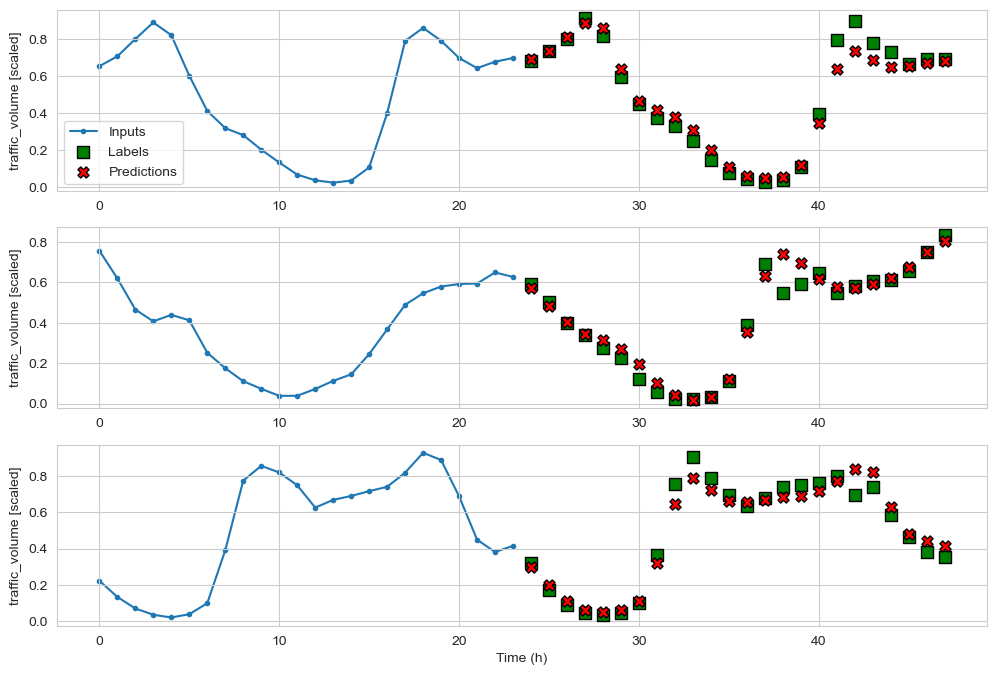

In [17]:
multi_window.plot(AR_LSTM)

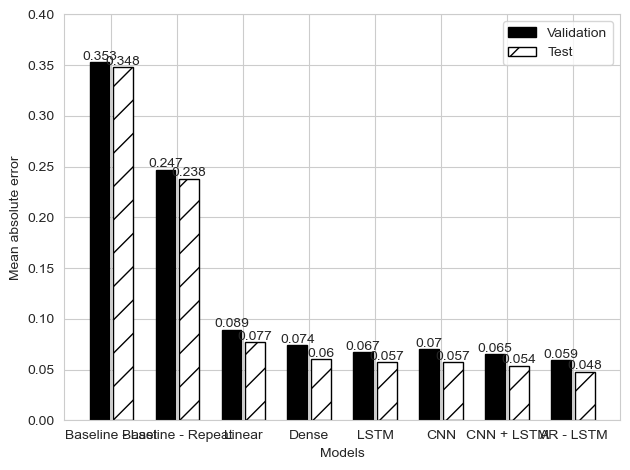

In [25]:
ms_mae_val.append(ms_val_performance['AR - LSTM'][1])
ms_mae_test.append(ms_performance['AR - LSTM'][1])

x = np.arange(8)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM', 'AR - LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.18, ms_mae_val, width=0.3, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.18, ms_mae_test, width=0.3, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.18, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

* As we can see for our case, we get the ARLSTM as the best overall model.